<a href="https://colab.research.google.com/github/tstreet24/Street_Portfolio/blob/main/SlotMarketSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import tensorflow as tf
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from arch import arch_model
import matplotlib.pyplot as plt
import pickle
import os
tf.random.set_seed(42)

# **INITIAL CODE TO GET PAST TWO YEARS OF DATA**

In [ ]:
# Function to fetch tickers
def fetch_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    sp500_tickers = sp500_table['Symbol'].tolist()
    return sp500_tickers

sp500_tickers = fetch_sp500_tickers()
print(sp500_tickers)


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DH

In [ ]:
# Pulling closing prices from beginning of 2022 to february 2024
sp500_tickers = fetch_sp500_tickers()

end_date = datetime.today()
start_date = datetime(2022, 1, 1)

all_closing_prices = pd.DataFrame()

for ticker in sp500_tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    all_closing_prices[ticker] = hist['Close']

print(all_closing_prices)


KeyboardInterrupt: 

In [ ]:
# Dropping a column that was NA
all_closing_prices = all_closing_prices.dropna(1)

<ipython-input-6-ecacc3cac505>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  all_closing_prices = all_closing_prices.dropna(1)


In [ ]:
all_closing_prices.to_csv("closing_prices.csv")

# **Data Preparation**

In [ ]:
# Read data
df = pd.read_csv("/content/drive/My Drive/HODL_Project/closing_prices.csv")
df.head(5)

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,2022-02-22 00:00:00-05:00,131.848373,66.999771,113.157043,134.771225,311.504822,438.399994,115.650002,19.725672,59.775093,...,26.563948,216.682327,461.913452,87.652527,62.030247,87.747414,119.439003,409.760010,117.489258,186.885986
1,2022-02-23 00:00:00-05:00,129.719040,65.419464,112.906662,135.882248,303.792664,429.450012,109.760002,19.293791,58.651398,...,27.113052,210.488632,452.326752,86.306313,61.080128,85.934158,117.051567,399.290009,117.116631,183.897400
2,2022-02-24 00:00:00-05:00,129.108078,65.303825,114.322220,134.502716,306.712646,463.820007,116.610001,19.641172,56.775391,...,26.969023,213.391327,456.132111,85.603516,60.986065,85.495468,116.830154,415.329987,117.976532,187.721619
3,2022-02-25 00:00:00-05:00,135.226562,66.864868,117.875534,138.456207,312.862976,465.540009,121.059998,19.819557,58.994221,...,27.626146,217.099777,466.335144,86.880432,63.243763,88.644272,119.102074,418.070007,121.053017,191.418060
4,2022-02-28 00:00:00-05:00,133.555435,66.084343,116.151833,136.817413,306.567108,467.679993,123.339996,19.932224,58.175251,...,28.157246,215.808609,466.677490,85.643105,63.337833,86.714043,118.004616,413.339996,121.521172,190.375961


In [ ]:
# Normalize (min-max)
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') # don't apply to 0th column, which is date
normalized_df = df.copy()
normalized_df.iloc[:, 1:] = (df.iloc[:, 1:] - df.iloc[:, 1:].min()) / (df.iloc[:, 1:].max() - df.iloc[:, 1:].min())
normalized_df.head(5)

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,2022-02-22 00:00:00-05:00,0.879285,0.566558,0.792784,0.162364,0.527625,0.453888,0.480023,0.475161,0.260061,...,0.000578,0.336389,0.051991,0.572481,0.386819,0.311003,0.451828,0.881971,0.382492,0.817779
1,2022-02-23 00:00:00-05:00,0.841037,0.521247,0.784301,0.184149,0.468720,0.428997,0.432671,0.447942,0.227345,...,0.054118,0.268740,0.034127,0.551167,0.337552,0.276636,0.388805,0.838366,0.374127,0.775071
2,2022-02-24 00:00:00-05:00,0.830062,0.517931,0.832258,0.157099,0.491023,0.524586,0.487740,0.469836,0.172726,...,0.040074,0.300444,0.041218,0.540041,0.332675,0.268321,0.382960,0.905168,0.393432,0.829721
3,2022-02-25 00:00:00-05:00,0.939965,0.562690,0.952640,0.234619,0.537999,0.529369,0.523515,0.481078,0.237326,...,0.104146,0.340949,0.060231,0.560257,0.449743,0.328001,0.442934,0.916580,0.462499,0.882545
4,2022-02-28 00:00:00-05:00,0.909947,0.540310,0.894243,0.202486,0.489911,0.535321,0.541844,0.488179,0.213482,...,0.155931,0.326846,0.060869,0.540668,0.454621,0.291417,0.413963,0.896881,0.473009,0.867652


In [ ]:
# Filter data to 2023 points
normalized_df['Date'] = pd.to_datetime(normalized_df['Date'], utc = True)
df_2023 = normalized_df[(normalized_df['Date'].dt.year == 2023) | (normalized_df['Date'].dt.year == 2022)]
df_2024_first_entry = normalized_df[normalized_df['Date'].dt.year == 2024].head(1)
df_initial = pd.concat([df_2023, df_2024_first_entry])
df_initial.tail(5)

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
463,2023-12-26 05:00:00+00:00,0.421159,0.983150,0.641949,0.522869,0.838029,0.898487,0.703192,0.439676,0.883987,...,0.834828,0.571965,0.731976,0.622071,0.371250,0.795108,0.720355,0.322810,0.470737,0.934555
464,2023-12-27 05:00:00+00:00,0.432290,0.992003,0.660830,0.527919,0.840997,0.892424,0.724576,0.434686,0.889484,...,0.826053,0.574250,0.737313,0.616227,0.361398,0.809471,0.735590,0.324018,0.464227,0.954517
465,2023-12-28 05:00:00+00:00,0.449076,0.994288,0.681397,0.525394,0.824026,0.890867,0.746201,0.439053,0.895270,...,0.816302,0.583644,0.729502,0.634075,0.379546,0.808337,0.727184,0.322186,0.475452,0.958224
466,2023-12-29 05:00:00+00:00,0.442538,1.000000,0.670270,0.529667,0.818851,0.893870,0.735349,0.432815,0.906553,...,0.806552,0.604177,0.732459,0.623809,0.380583,0.809093,0.730862,0.313773,0.477023,0.961218
467,2024-01-02 05:00:00+00:00,0.454553,0.971440,0.662853,0.623866,0.788486,0.847897,0.664362,0.438429,0.929119,...,0.873830,0.590525,0.703724,0.678932,0.461474,0.796053,0.688047,0.291491,0.470064,0.949812


# Important Functions

In [ ]:
# Function to properly shape X and y for LSTM
def create_sequences(series, lag):
    inputs = []
    targets = []
    for i in range(len(series) - lag):
        inputs.append(series[i:(i + lag)])
        targets.append(series[i + lag])
    return np.array(inputs), np.array(targets)

In [ ]:
# Function to perform walk forward validation with varying parameters
def walk_forward_validation(series, lag, units, dropout, val_steps, epochs):
    series = np.array(series) if not isinstance(series, np.ndarray) else series

    X, y = create_sequences(series, lag)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split_idx = len(X) - val_steps

    mses = []

    # Define architecture
    input_layer = keras.Input(shape=(lag, 1))
    lstm_layer = keras.layers.LSTM(units, activation='relu')(input_layer)
    dropout_layer = keras.layers.Dropout(dropout)(lstm_layer)
    output_layer = keras.layers.Dense(1)(dropout_layer)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # Validation loop
    for step in range(val_steps - 1):
        X_train, y_train = X[:split_idx + step], y[:split_idx + step]
        X_val, y_val = X[split_idx + step:split_idx + step + 1], y[split_idx + step:split_idx + step + 1]


        model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

        mse = model.evaluate(X_val, y_val, verbose=0)[1]  # [1] for mse
        mses.append(mse)

    # Return the MSEs for each validation step and the final model
    return mses, model


# Model Building and Evaluation, ONE STOCK for EXPLORATION

In [ ]:
series = df_initial.iloc[:,1]
lag = 10
X, y = create_sequences(series, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
X_train = X[:-1]
X_test = X[-1:]
y_train = y[:-1]
y_test = y[-1:]

In [ ]:
input = keras.Input(shape=(lag, 1))
lstm = keras.layers.LSTM(30, activation='relu')(input)
dropout = keras.layers.Dropout(0.2)(lstm)
output = keras.layers.Dense(1)(dropout)
model = keras.Model(inputs=input, outputs=output)




model.compile(optimizer='adam', loss='mse', metrics = ['mse'])

In [ ]:
model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=32)

Epoch 1/20
15/15 [==============================] - 2s 6ms/step - loss: 0.2392 - mse: 0.2392
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 0.1055 - mse: 0.1055
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 0.0236 - mse: 0.0236
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0147 - mse: 0.0147
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0136 - mse: 0.0136
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0124 - mse: 0.0124
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0127 - mse: 0.0127
Epoch 8/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0099 - mse: 0.0099
Epoch 9/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0108 - mse: 0.0108
Epoch 10/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0105 - mse: 0.0105
Epoch 11/20
15/15 [==============================] - 0s 6ms/step - lo

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 230ms/step - loss: 0.0026 - mse: 0.0026


[0.002556488150730729, 0.002556488150730729]

# EXPERIMENT - Determining adequate number of epochs

In [ ]:
# Function to perform epoch experiment with walk forward validation
def epoch_experiment(df, lag, units, dropout, val_steps, epoch_values):

    # Dictionary with results
    results = {column: {} for column in df.columns}

    for column in df.columns:
        print(f"Processing column: {column}")
        series = df[column].values

        for epochs in epoch_values:
            mses, _ = walk_forward_validation(series, lag, units, dropout, val_steps, epochs)
            avg_mse = np.mean(mses)
            results[column][epochs] = avg_mse

    # Plotting
    for column in df.columns:
        plt.figure(figsize=(10, 6))
        epochs_list = list(results[column].keys())
        avg_mses = list(results[column].values())

        model_params_label = f'Walk Forward Validation MSE - Lag: {lag}, Units: {units}, Dropout: {dropout}'

        plt.plot(epochs_list, avg_mses, marker='o', label=model_params_label)

        plt.title(f'Walk Forward Validation MSE by Epoch for {column}')
        plt.xlabel('Epochs')
        plt.ylabel('Average MSE')
        plt.xticks(epochs_list)
        plt.grid(False)

        plt.legend()
        plt.show()

Processing column: TSLA
Processing column: UNH
Processing column: ETR


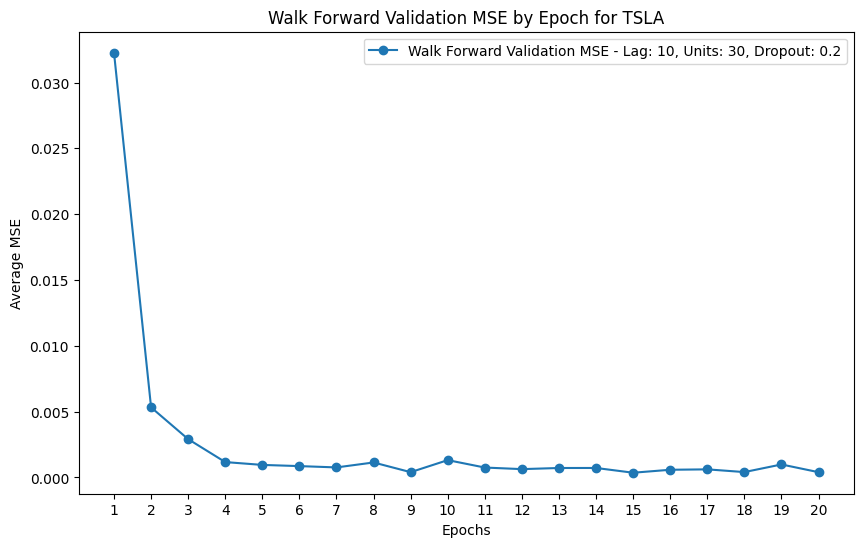

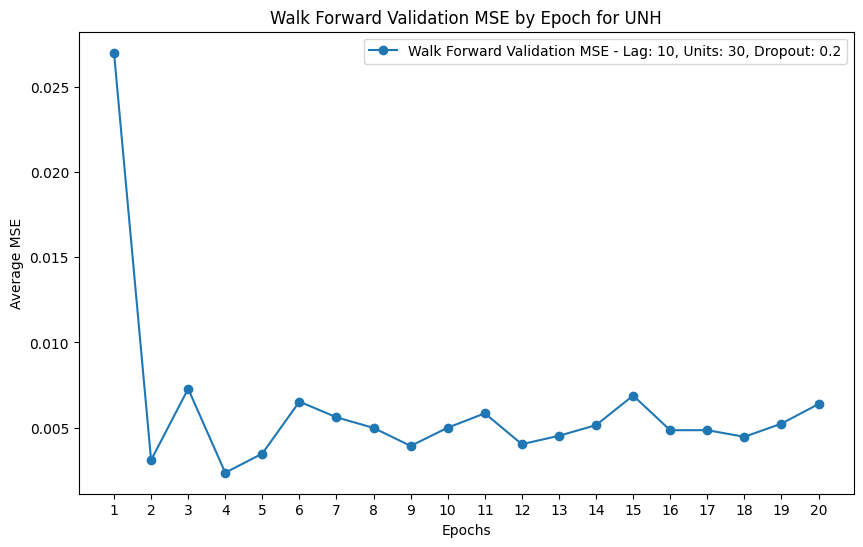

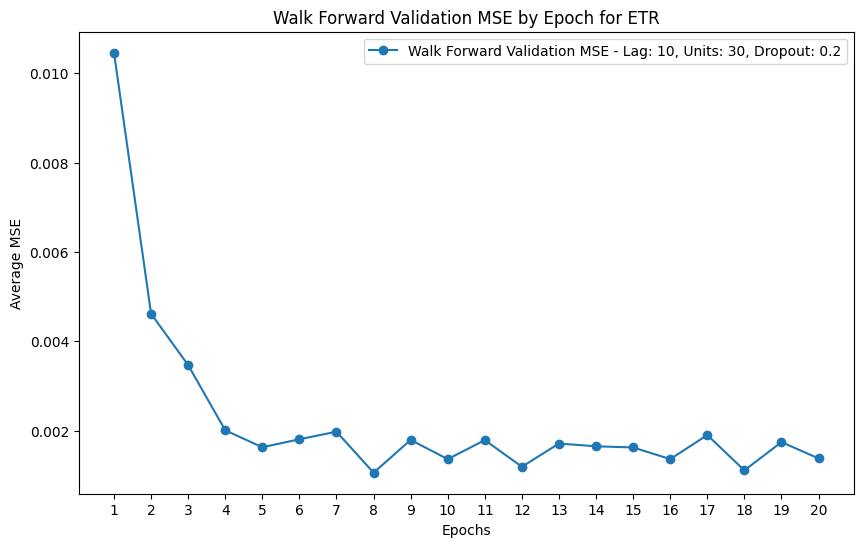

In [ ]:
# Parameters for experiment
lag = 10
units = 30
dropout = 0.2
val_steps = 8
epoch_range = range(1,21)

# Randomly pick columns (TSLA, UNH, ETR)
np.random.seed(15773)
random_num = np.random.choice(range(1, df_initial.shape[1] + 1), 3, replace=False)
df = df_initial.iloc[:,[random_num[0]
                        ,random_num[1]
                        ,random_num[2]
                        ]]

# Call function
epoch_experiment(df, lag, units, dropout, val_steps, epoch_range)

### Conclusion: Around 5 epochs seems reasonable

# EXPERIMENT - Determine lag length

In [ ]:
# Function to perform lag experiment using walk forward validation
def lag_experiment(df, lag_values, units, dropout, val_steps, constant_epochs):
    # List to store all results
    results = []

    for column in df.columns:
        print(f"Processing column: {column}")
        series = df[column].values

        for lag in lag_values:
            mses, _ = walk_forward_validation(series, lag, units, dropout, val_steps, constant_epochs)
            avg_mse = np.mean(mses)

            results.append({
                'Column': column,
                'Lag': lag,
                'Average_MSE': avg_mse
            })

    results_df = pd.DataFrame(results)

    return results_df

In [ ]:
# Parameters for experiment
lag_values = [7, 14, 28]
units = 30
dropout = 0.2
val_steps = 8
epochs = 5

# Randomly pick columns
np.random.seed(15773)
random_num = np.random.choice(range(1, df_initial.shape[1] + 1), 3, replace=False)
df = df_initial.iloc[:,[random_num[0]
                        ,random_num[1]
                        ,random_num[2]
                        ]]

# Call function
results = lag_experiment(df, lag_values, units, dropout, val_steps, epochs)
lag_agg = results.groupby('Lag')['Average_MSE'].mean().reset_index()
lag_agg

Processing column: TSLA
Processing column: UNH
Processing column: ETR


,Lag,Average_MSE
0,7,0.002567
1,14,0.003883
2,28,0.003835


### CONCLUSION: We will use a lag of 7 herein

# EXPERIMENT - Parameter tuning with keras.tuner, no walk forward validation, for warm start

In [ ]:
# 0 - TSLA
series = df.iloc[:,0]
lag = 7
X, y = create_sequences(series, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X[:-1]
X_test = X[-1:]
y_train = y[:-1]
y_test = y[-1:]


def build_model(hp):
    input_layer = keras.Input(shape=(lag, 1))
    lstm_layer = keras.layers.LSTM(
        hp.Int('lstm_units', min_value=10, max_value=100, step=10), activation='relu')(input_layer)
    dropout_layer = keras.layers.Dropout(
        hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05))(lstm_layer)
    output_layer = keras.layers.Dense(1)(dropout_layer)
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='tuner0'
)

tuner.search(X_train, y_train, epochs=5, validation_data = (X_test, y_test))

Trial 10 Complete [00h 00m 05s]
val_loss: 3.510986061883159e-05

Best val_loss So Far: 3.838182465187856e-07
Total elapsed time: 00h 00m 53s


In [ ]:
# 0 - TSLA
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'lstm_units': 90, 'dropout_rate': 0.1}

In [ ]:
# 1 - UNH
series = df.iloc[:,1]
lag = 7
X, y = create_sequences(series, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X[:-1]
X_test = X[-1:]
y_train = y[:-1]
y_test = y[-1:]


def build_model(hp):
    input_layer = keras.Input(shape=(lag, 1))
    lstm_layer = keras.layers.LSTM(
        hp.Int('lstm_units', min_value=10, max_value=100, step=10), activation='relu')(input_layer)
    dropout_layer = keras.layers.Dropout(
        hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05))(lstm_layer)
    output_layer = keras.layers.Dense(1)(dropout_layer)
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='tuner1'
)

tuner.search(X_train, y_train, epochs=5, validation_data = (X_test, y_test))

Reloading Tuner from ./tuner1/tuner0.json


In [ ]:
# 1 - UNH
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'lstm_units': 100, 'dropout_rate': 0.0}

In [ ]:
# 2 - ETR
series = df.iloc[:,2]
lag = 7
X, y = create_sequences(series, lag)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train = X[:-1]
X_test = X[-1:]
y_train = y[:-1]
y_test = y[-1:]


def build_model(hp):
    input_layer = keras.Input(shape=(lag, 1))
    lstm_layer = keras.layers.LSTM(
        hp.Int('lstm_units', min_value=10, max_value=100, step=10), activation='relu')(input_layer)
    dropout_layer = keras.layers.Dropout(
        hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05))(lstm_layer)
    output_layer = keras.layers.Dense(1)(dropout_layer)
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='mse')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='tuner2'
)

tuner.search(X_train, y_train, epochs=5, validation_data = (X_test, y_test))

Trial 10 Complete [00h 00m 05s]
val_loss: 1.914045787998475e-05

Best val_loss So Far: 5.941438416812161e-07
Total elapsed time: 00h 00m 53s


In [ ]:
# 2 - ETR
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'lstm_units': 50, 'dropout_rate': 0.15000000000000002}

### CONCLUSION - for stock 0, 90 units and 10% dropout   ;    for stock 1, 100 units and 0% dropout    ;    for stock 2, 50 units and 15% dropout

# EXPERIMENT - Manual parameter tuning for units and dropout rate using warm starts from previous experiment

In [ ]:
# Function to perform manual parameter tuning
def parameter_tuning(df, lag, unit_range, dropout_range, val_steps, epochs):
    # Initialize a list to store the results
    all_results = []

    for column in df.columns:
        series = df[column].values

        for units in unit_range:

            for dropout in dropout_range:
                mses, _ = walk_forward_validation(series, lag, units, dropout, val_steps, epochs)
                avg_mse = np.mean(mses)

                all_results.append({
                    'Column': column,
                    'Units': units,
                    'Dropout': dropout,
                    'Average_MSE': avg_mse
                })

    results_df = pd.DataFrame(all_results)

    return results_df


In [ ]:
# Parameters for experiment
lag = 7
unit_range = [80, 90, 100, 110]
dropout_range = [0, 0.05, 0.1, 0.15]
val_steps = 8
epochs = 5

# Randomly pick columns
np.random.seed(15773)
random_num = np.random.choice(range(1, df_initial.shape[1] + 1), 3, replace=False)
df = df_initial.iloc[:,[random_num[0]
                        ,random_num[1]
                        ,random_num[2]
                        ]]

# Call function
results = parameter_tuning(df, lag, unit_range, dropout_range, val_steps, epochs)
lag_agg = results.groupby(['Units', 'Dropout'])['Average_MSE'].mean().reset_index()
lag_agg.rename(columns={'Average_MSE': 'Aggregated_Average_MSE'}, inplace=True)

In [ ]:
lag_agg

,Units,Dropout,Aggregated_Average_MSE
0,80,0.00,0.002323
1,80,0.05,0.001980
2,80,0.10,0.002343
3,80,0.15,0.002919
4,90,0.00,0.002442
5,90,0.05,0.002498
6,90,0.10,0.002101
7,90,0.15,0.001956
8,100,0.00,0.002523
9,100,0.05,0.002287


### CONCLUSION - 90 units, 15% dropout rate

# EXPERIMENT - Stacking LSTMS

In [ ]:
# Function to create architecture based on number of stacks
def build_stacks(lag, units, dropout, num_stacks):
    input_layer = keras.Input(shape=(lag, 1))
    x = input_layer

    # Adjust units based on the number of stacks
    adjusted_units = int(units / num_stacks)

    for _ in range(num_stacks):
        x = keras.layers.LSTM(adjusted_units, activation='relu', return_sequences=(_ < num_stacks - 1))(x)
        x = keras.layers.Dropout(dropout)(x)

    output_layer = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model


In [ ]:
# Function to perform stacks experiment using walk forward validation
def evaluate_stacked_models(df, lag, units, dropout, val_steps, epochs, stack_options):
    results = []

    for column in df.columns:
        series = df[column].values

        for num_stacks in stack_options:
            print(f"Evaluating: {column} with {num_stacks} Stacks")
            model = build_stacks(lag, units, dropout, num_stacks)

            mses, _ = walk_forward_validation(series, lag, units, dropout, val_steps, epochs)
            avg_mse = np.mean(mses)

            results.append({
                'Column': column,
                'Num_Stacks': num_stacks,
                'Average_MSE': avg_mse
            })

    return pd.DataFrame(results)


In [ ]:
# Parameters for experiment
lag = 7
units = 90
dropout = 0.15
val_steps = 8
epochs = 5
stack_options = range(1, 11)

# Randomly pick columns
np.random.seed(15773)
random_num = np.random.choice(range(1, df_initial.shape[1] + 1), 3, replace=False)
df = df_initial.iloc[:,[random_num[0]
                        ,random_num[1]
                        ,random_num[2]
                        ]]

# Call function
results = evaluate_stacked_models(df, lag, units, dropout, val_steps, epochs, stack_options)
lag_agg = results.groupby(['Num_Stacks'])['Average_MSE'].mean().reset_index()
lag_agg.rename(columns={'Average_MSE': 'Aggregated_Average_MSE'}, inplace=True)

Evaluating: TSLA with 1 Stacks
Evaluating: TSLA with 2 Stacks
Evaluating: TSLA with 3 Stacks
Evaluating: TSLA with 4 Stacks
Evaluating: TSLA with 5 Stacks
Evaluating: TSLA with 6 Stacks
Evaluating: TSLA with 7 Stacks
Evaluating: TSLA with 8 Stacks
Evaluating: TSLA with 9 Stacks
Evaluating: TSLA with 10 Stacks
Evaluating: UNH with 1 Stacks
Evaluating: UNH with 2 Stacks
Evaluating: UNH with 3 Stacks
Evaluating: UNH with 4 Stacks
Evaluating: UNH with 5 Stacks
Evaluating: UNH with 6 Stacks
Evaluating: UNH with 7 Stacks
Evaluating: UNH with 8 Stacks
Evaluating: UNH with 9 Stacks
Evaluating: UNH with 10 Stacks
Evaluating: ETR with 1 Stacks
Evaluating: ETR with 2 Stacks
Evaluating: ETR with 3 Stacks
Evaluating: ETR with 4 Stacks
Evaluating: ETR with 5 Stacks
Evaluating: ETR with 6 Stacks
Evaluating: ETR with 7 Stacks
Evaluating: ETR with 8 Stacks
Evaluating: ETR with 9 Stacks
Evaluating: ETR with 10 Stacks


In [ ]:
lag_agg

,Num_Stacks,Aggregated_Average_MSE
0,1,0.002069
1,2,0.002103
2,3,0.002075
3,4,0.002171
4,5,0.002022
5,6,0.001827
6,7,0.001930
7,8,0.002380
8,9,0.002354
9,10,0.002404


### Conclusion: 6 stacks are best

# Creating models

In [ ]:
base_save_path = '/content/drive/My Drive/HODL_Project/Models/'

for i in range(498, 498):
  series = df_initial.iloc[:,i]
  lag = 7
  X, y = create_sequences(series, lag)
  X = X.reshape((X.shape[0], X.shape[1], 1))

  X_train = X[:-1]
  X_test = X[-1:]
  y_train = y[:-1]
  y_test = y[-1:]

  input = keras.Input(shape=(lag, 1))
  lstm_1 = keras.layers.LSTM(15, activation='relu', return_sequences=True)(input)
  dropout_1 = keras.layers.Dropout(0.15)(lstm_1)
  lstm_2 = keras.layers.LSTM(15, activation='relu', return_sequences=True)(dropout_1)
  dropout_2 = keras.layers.Dropout(0.15)(lstm_2)
  lstm_3 = keras.layers.LSTM(15, activation='relu', return_sequences=True)(dropout_2)
  dropout_3 = keras.layers.Dropout(0.15)(lstm_3)
  lstm_4 = keras.layers.LSTM(15, activation='relu', return_sequences=True)(dropout_3)
  dropout_4 = keras.layers.Dropout(0.15)(lstm_4)
  lstm_5 = keras.layers.LSTM(15, activation='relu', return_sequences=True)(dropout_4)
  dropout_5 = keras.layers.Dropout(0.15)(lstm_5)
  lstm_6 = keras.layers.LSTM(15, activation='relu')(dropout_5)
  dropout_6 = keras.layers.Dropout(0.15)(lstm_6)
  output = keras.layers.Dense(1)(dropout_6)
  model = keras.Model(inputs=input, outputs=output)

  model.compile(optimizer='adam', loss='mse', metrics = ['mse'])


  model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0, validation_data=(X_test, y_test))

  model_save_path = os.path.join(base_save_path, f'model_column_{i}.h5')
  model.save(model_save_path)
  print(f'Model saved to {model_save_path}')



# GARCH MODELS

In [ ]:
df

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,2022-02-22 00:00:00-05:00,131.848373,66.999771,113.157043,134.771225,311.504822,438.399994,115.650002,19.725672,59.775093,...,26.563948,216.682327,461.913452,87.652527,62.030247,87.747414,119.439003,409.760010,117.489258,186.885986
1,2022-02-23 00:00:00-05:00,129.719040,65.419464,112.906662,135.882248,303.792664,429.450012,109.760002,19.293791,58.651398,...,27.113052,210.488632,452.326752,86.306313,61.080128,85.934158,117.051567,399.290009,117.116631,183.897400
2,2022-02-24 00:00:00-05:00,129.108078,65.303825,114.322220,134.502716,306.712646,463.820007,116.610001,19.641172,56.775391,...,26.969023,213.391327,456.132111,85.603516,60.986065,85.495468,116.830154,415.329987,117.976532,187.721619
3,2022-02-25 00:00:00-05:00,135.226562,66.864868,117.875534,138.456207,312.862976,465.540009,121.059998,19.819557,58.994221,...,27.626146,217.099777,466.335144,86.880432,63.243763,88.644272,119.102074,418.070007,121.053017,191.418060
4,2022-02-28 00:00:00-05:00,133.555435,66.084343,116.151833,136.817413,306.567108,467.679993,123.339996,19.932224,58.175251,...,28.157246,215.808609,466.677490,85.643105,63.337833,86.714043,118.004616,413.339996,121.521172,190.375961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-14 00:00:00-05:00,90.909996,81.169998,112.059998,174.419998,370.980011,604.659973,178.699997,16.139999,78.422897,...,33.049999,275.160004,944.400024,104.961227,58.680000,123.798927,133.342682,252.960007,121.839996,184.080002
498,2024-02-15 00:00:00-05:00,92.379997,81.000000,113.639999,176.589996,371.510010,590.440002,176.759995,16.780001,79.665024,...,34.189999,277.440002,943.690002,105.480003,59.009998,124.058167,134.725769,283.750000,124.400002,189.649994
499,2024-02-16 00:00:00-05:00,91.250000,80.089996,114.010002,177.490005,369.480011,546.659973,173.869995,16.770000,78.879997,...,34.310001,277.309998,935.799988,105.129997,59.070000,123.430000,133.880005,275.459991,124.709999,188.389999
500,2024-02-20 00:00:00-05:00,91.820000,79.639999,116.639999,175.750000,362.950012,541.909973,165.690002,16.420000,78.779999,...,34.110001,275.640015,935.150024,103.230003,59.189999,124.099998,133.949997,271.929993,124.980003,186.550003


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df_2023 = df[(df['Date'].dt.year == 2023) | (df['Date'].dt.year == 2022)]
df_2024_first_entry = df[df['Date'].dt.year == 2024].head(1)
df = pd.concat([df_2023, df_2024_first_entry])

In [ ]:
log_returns = np.log(df.iloc[:, 1:] / df.iloc[:, 1:].shift(1))
log_returns = log_returns.dropna()
df = log_returns

In [ ]:
df

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
1,-0.016282,-0.023869,-0.002215,0.008210,-0.025069,-0.020626,-0.052272,-0.022138,-0.018978,-0.035015,...,0.020460,-0.029001,-0.020973,-0.015478,-0.015436,-0.020881,-0.020191,-0.025884,-0.003177,-0.016121
2,-0.004721,-0.001769,0.012459,-0.010204,0.009566,0.076991,0.060539,0.017845,-0.032508,0.016919,...,-0.005326,0.013696,0.008378,-0.008176,-0.001541,-0.005118,-0.001893,0.039385,0.007315,0.020582
3,0.046302,0.023623,0.030608,0.028970,0.019854,0.003701,0.037451,0.009041,0.038337,0.042621,...,0.024074,0.017229,0.022122,0.014806,0.036351,0.036168,0.019260,0.006576,0.025743,0.019500
4,-0.012435,-0.011742,-0.014731,-0.011907,-0.020329,0.004586,0.018658,0.005669,-0.013979,-0.025523,...,0.019042,-0.005965,0.000734,-0.014344,0.001486,-0.022016,-0.009257,-0.011378,0.003860,-0.005459
5,-0.026586,-0.028846,-0.020521,-0.000542,-0.014888,-0.002141,-0.080239,-0.026732,-0.043663,0.011972,...,0.012391,-0.015276,-0.022663,-0.058056,-0.012254,-0.024929,-0.021106,-0.018952,0.005287,-0.005749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.016602,0.001467,0.001833,-0.002067,-0.002882,-0.000819,0.026926,0.013521,0.003309,0.001718,...,-0.000569,-0.004174,0.000700,0.006394,0.003057,0.008663,0.001998,0.022353,0.009101,0.002663
464,0.005810,0.003780,0.005114,0.001680,0.001103,-0.003651,0.018378,-0.004141,0.002322,0.000072,...,-0.002566,0.000878,0.003458,-0.004074,-0.003083,0.006667,0.004443,0.001052,-0.002391,0.007136
465,0.008698,0.000973,0.005541,-0.000840,-0.006323,-0.000940,0.018248,0.003624,0.002439,-0.000358,...,-0.002859,0.003600,-0.005065,0.012391,0.005671,-0.000525,-0.002449,-0.001597,0.004119,0.001320
466,-0.003379,0.002429,-0.002994,0.001421,-0.001936,0.001812,-0.009116,-0.005181,0.004738,-0.003619,...,-0.002867,0.007825,0.001921,-0.007109,0.000323,0.000350,0.001072,-0.007363,0.000575,0.001065


In [ ]:
base_save_path = '/content/drive/My Drive/HODL_Project/GARCH_Models/'
for i in range(0,df.shape[1]):  # Start=1 for naming files starting from 1
    # Select the series excluding the last row
    series = df.iloc[:,i]

    # Fit a GARCH(1,1) model
    model = arch_model(series, vol='Garch', p=1, q=1, mean='constant', dist='Normal')
    results = model.fit(disp='off')

    # Construct the save path for the model
    model_save_path = os.path.join(base_save_path, f'garch_model_{i+1}.pkl')

    # Save the model using pickle
    with open(model_save_path, 'wb') as f:
        pickle.dump(results, f)

    print(f"Model saved to {model_save_path}")

# LSTM Evaluation

## Functions

In [ ]:
def update_model(model, train_series, test_series):
  norm_preds = []
  mse = []

  train_series = np.array(train_series)
  test_series = np.array(test_series)

  size_test = len(test_series)

  for i in range(1,size_test):

      #Prep Data
      model_series = np.append(train_series, test_series[0:i+1])

      #Prep data for model
      X, y = create_sequences(model_series, 7)
      X = X.reshape((X.shape[0], X.shape[1], 1))
      X_train = X[:-1]
      X_test = X[-1:]
      y_train = y[:-1]
      y_test = y[-1:]

      #Update model
      updated_model = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose = 0)
      # Predict the stock price for the next day
      pred_norm_price = model.predict(X_test)[0][0]
      #mse
      y_test = y_test[0]
      error = np.square(y_test - pred_norm_price)

      # Store the prediction & error
      norm_preds.append(pred_norm_price)
      mse.append(error)

      #Save Model if last run
      if i == size_test - 1:
        model_filename = f'/content/drive/My Drive/HODL_Project/Updated_LSTM/model_column_{j}.h5'
        model.save(model_filename)

  #return dataframe
  norm_preds = pd.DataFrame(norm_preds)
  mse = pd.DataFrame(mse)

  return norm_preds, mse

## Loop through Stocks

In [ ]:
#Read in Data
prices_df = pd.read_csv("/content/drive/My Drive/HODL_Project/closing_prices.csv")

In [ ]:
#Normalize Data
normalized_df = prices_df.copy()
min_series = prices_df.iloc[:, 1:].min()
max_series = prices_df.iloc[:, 1:].max()
normalized_df.iloc[:, 1:] = (prices_df.iloc[:, 1:] - min_series) / (max_series - min_series)

In [ ]:
#Update each time
last_pred_date = '1/2/2024'

#Initial Split
train_df = normalized_df[normalized_df['Date'] < last_pred_date]
test_df = normalized_df[normalized_df['Date'] >= last_pred_date]

#date range
date_range = test_df['Date'].tolist()

In [ ]:
#Intialize DataFrames - First Time Only
norm_preds_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])
mse_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

In [ ]:
#loop through all stocks
for j in range(start_index, prices_df.shape[1]):
  print(j)
  #Load Model
  model_filename = f'/content/drive/My Drive/HODL_Project/LSTM_Models/model_column_{j}.h5'
  model = load_model(model_filename)
  model.compile(optimizer='adam', loss='mse')

  #Series for jth stock
  train_series = train_df.iloc[:,j]
  test_series = test_df.iloc[:,j]

  #Update the model
  norm_preds, mse = update_model(model, train_series, test_series)

  norm_preds_df = pd.concat([norm_preds_df, norm_preds], axis=1)
  mse_df = pd.concat([mse_df, mse], axis=1)

  #Save DataFrames
  norm_preds_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/norm_preds.csv', index=False)
  mse_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/mse.csv', index=False)


In [ ]:
#Once all stocks are have run - update columns
prices_df_cols = list(prices_df.columns)
norm_preds_df.columns = prices_df_cols
mse_df.columns = prices_df_cols

In [ ]:
# De-normalize predictions
preds_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

for j in range(1, norm_preds_df.shape[1]):
  de_norm = norm_preds_df.iloc[:,j] * (max_series[j-1] - min_series[j-1]) + min_series[j-1]
  preds_df = pd.concat([preds_df, de_norm], axis=1)

#Rename columns
preds_df.columns = prices_df_cols

In [ ]:
#save csv with col names
norm_preds_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/norm_preds.csv', index=False)
preds_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/preds.csv', index=False)
mse_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/mse.csv', index=False)


## Evaluation Measures

In [ ]:
#Read in Files if not already loaded - commented out because assumed loaded
prices_df = pd.read_csv("/content/drive/My Drive/HODL_Project/closing_prices.csv")
norm_preds_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/norm_preds.csv")
preds_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/preds.csv")
mse_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/mse.csv")

#Normalize Data
normalized_df = prices_df.copy()
min_series = prices_df.iloc[:, 1:].min()
max_series = prices_df.iloc[:, 1:].max()
normalized_df.iloc[:, 1:] = (prices_df.iloc[:, 1:] - min_series) / (max_series - min_series)

#Assure last_pred_date & price_df_cols is defined
last_pred_date = pd.to_datetime('1/2/2024').tz_localize('UTC')
prices_df_cols = list(prices_df.columns)

In [ ]:
#Get train DF
test_df_norm = normalized_df[pd.to_datetime(normalized_df['Date']) > last_pred_date]
test_df = prices_df[pd.to_datetime(prices_df['Date'])  > last_pred_date]

In [ ]:
#Define date_range
date_range = test_df['Date'].tolist()

In [ ]:
test_df_norm.head()

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
467,2024-01-02 00:00:00-05:00,0.454553,0.971440,0.662853,0.623866,0.788486,0.847897,0.664362,0.438429,0.929119,...,0.873830,0.590525,0.703724,0.678932,0.461474,0.796053,0.688047,0.291491,0.470064,0.949812
468,2024-01-03 00:00:00-05:00,0.415505,0.893471,0.651727,0.636297,0.719994,0.824869,0.638154,0.412853,0.926515,...,0.950858,0.597952,0.695746,0.669929,0.467178,0.756178,0.689887,0.227104,0.449410,0.897912
469,2024-01-04 00:00:00-05:00,0.422219,0.912607,0.700952,0.655719,0.713678,0.811686,0.643701,0.409110,0.900767,...,0.903081,0.585500,0.708820,0.672772,0.474956,0.770730,0.679117,0.228978,0.443348,0.913738
470,2024-01-05 00:00:00-05:00,0.429640,0.902896,0.694883,0.668926,0.710101,0.804873,0.664362,0.404743,0.912918,...,0.876755,0.578728,0.713898,0.695516,0.474956,0.767328,0.669924,0.227812,0.438409,0.925288
471,2024-01-08 00:00:00-05:00,0.434411,0.909465,0.748828,0.655136,0.738487,0.849232,0.725460,0.421586,0.917257,...,0.886505,0.614772,0.720444,0.717628,0.467178,0.780557,0.677804,0.262796,0.483085,0.943823


### Mean Absolute Error

In [ ]:
#Calc MAE for all stocks

mae_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

for j in range(1, preds_df.shape[1]):
  mae_list = []
  for i in range(0, preds_df.shape[0]):
    mae = abs(preds_df.iloc[i,j] - test_df.iloc[i,j])
    mae_list.append(mae)

  mae_df_j = pd.DataFrame(mae_list)
  mae_df = pd.concat([mae_df, mae_df_j], axis=1)

mae_df.columns = prices_df_cols

In [ ]:
#Rolling MAE - does not include that date
rolling_mae_7day  = pd.DataFrame(data=date_range[2:], columns = ['Date'])
for j in range(1, mae_df.shape[1]):
  col = mae_df.iloc[:,j].rolling(window=7).mean()
  rolling_mae_7day = pd.concat([rolling_mae_7day, col], axis=1)

rolling_mae_7day.columns = prices_df_cols
rolling_mae_7day = rolling_mae_7day.iloc[:-1]

### Forecasted Change & MDE

In [ ]:
#Initalize DFs
#Forecasted Change
delta_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])
#Forecasted % Change
delta_perc_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])
#Actual Price Change
actual_delta_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])
#If actual and predicted change have same sign
directional_error_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])


In [ ]:
for j in range(1, preds_df.shape[1]):
  #Initialize Lists
  delta_list = []
  delta_perc_list = []
  actual_delta_list = []
  directional_error_list = []
  for i in range(0, preds_df.shape[0]):
    #Get forecasted change & % change
    delta = preds_df.iloc[i,j] - test_df.iloc[i,j] #same i b/c test_df starts on 1/2 but pred_df on 1/3
    delta_perc = delta / test_df.iloc[i,j]
    #Append to list
    delta_list.append(delta)
    delta_perc_list.append(delta_perc)

    #Get Actual Change
    actual_delta = test_df.iloc[i+1,j] - test_df.iloc[i,j]
    actual_delta_list.append(actual_delta)

    #Directional Error
    #Calc directional error : 0 if wrong 1 if right
    if actual_delta > 0 and delta > 0:
      directional_error = 1
    elif actual_delta < 0 and delta < 0:
      directional_error = 1
    else:
      directional_error = 0
    directional_error_list.append(directional_error)

  #Join dfs
  delta_df = pd.concat([delta_df, pd.DataFrame(delta_list)], axis=1)
  delta_perc_df = pd.concat([delta_perc_df, pd.DataFrame(delta_perc_list)], axis=1)
  actual_delta_df = pd.concat([actual_delta_df, pd.DataFrame(actual_delta_list)], axis=1)
  directional_error_df = pd.concat([directional_error_df, pd.DataFrame(directional_error_list)], axis=1)


In [ ]:
#Rename Columns
delta_df.columns = prices_df_cols
delta_perc_df.columns = prices_df_cols
actual_delta_df.columns = prices_df_cols
directional_error_df.columns = prices_df_cols

In [ ]:
#Make a 7 day rolling MDE (output is a percentage)
rolling_mde_7day  = pd.DataFrame(data=date_range[2:], columns = ['Date'])
for j in range(1, directional_error_df.shape[1]):
  col = directional_error_df.iloc[:,j].rolling(window=7).mean() * 100
  rolling_mde_7day = pd.concat([rolling_mde_7day, col], axis=1)

rolling_mde_7day.columns = prices_df_cols
rolling_mde_7day = rolling_mde_7day.iloc[:-1]

### Save dfs needs for agent

In [ ]:
delta_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/delta_df.csv', index = False)
rolling_mde_7day.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/rolling_mde_7day.csv', index = False)
delta_perc_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/delta_perc_df.csv', index = False)
rolling_mae_7day.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/rolling_mae_7day.csv', index = False)

## See how 1 stock performs DFs

In [ ]:
stock = 'AAPL'
stock_df = test_df[['Date', stock]]
stock_df.rename(columns = {stock:'Actual'}, inplace = True)
stock_df = stock_df.merge(preds_df[['Date', stock]],
                        on = 'Date',
                        how = 'inner')
stock_df.rename(columns = {stock:'Predicted'}, inplace = True)

<ipython-input-101-fc938b34c6db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.rename(columns = {stock:'Actual'}, inplace = True)


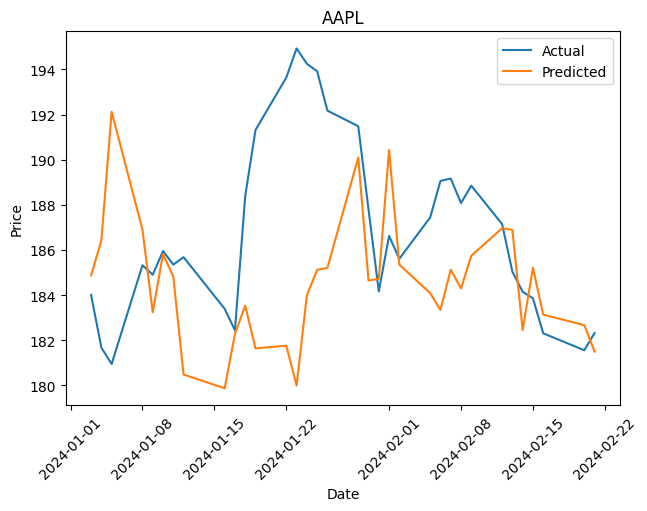

In [ ]:
plt.plot(pd.to_datetime(stock_df['Date']), stock_df['Actual'])
plt.plot(pd.to_datetime(stock_df['Date']), stock_df['Predicted'])
plt.legend(['Actual', 'Predicted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.title(stock)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Calc Baseline MSE & MAE

In [ ]:
baseline_mse_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

In [ ]:
for j in range(1, normalized_df.shape[1]):

  mse_list = []

  for i in range(1, normalized_df.shape[0]):
    mse = np.square(normalized_df.iloc[i-1,j] - normalized_df.iloc[i,j])
    mse_list.append(mse)

  baseline_mse_df = pd.concat([baseline_mse_df, pd.DataFrame(data=mse_list, columns = [prices_df_cols[j]])], axis=1)

In [ ]:
baseline_mae_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

for j in range(1, test_df.shape[1]):

  mae_list = []

  for i in range(1, test_df.shape[0]):
    mae = abs(test_df.iloc[i,j] - test_df.iloc[i-1,j])
    mae_list.append(mae)

  baseline_mae_df = pd.concat([baseline_mae_df, pd.DataFrame(data=mae_list, columns = [prices_df_cols[j]])], axis=1)

## Compare NMSE to baseline

In [ ]:
#LSTM
mean_mse = mse_df.mean()
average_mse_df = mean_mse.to_frame(name='Average MSE')

# Reset the index to make the stock names a column
average_mse_df.reset_index(inplace=True)
average_mse_df.rename(columns={'index': 'Stock'}, inplace=True)

<ipython-input-106-aff0a75713a5>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_mse = mse_df.mean()


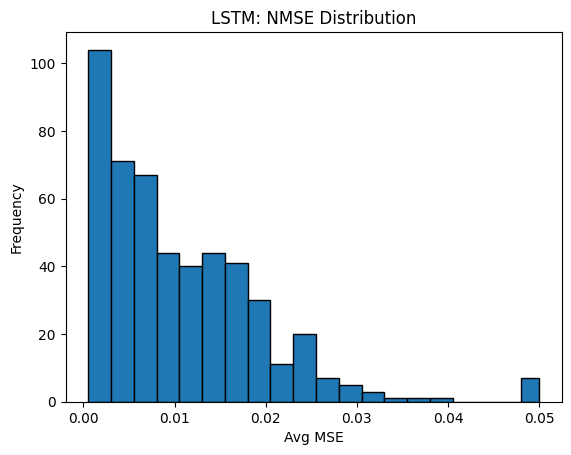

In [ ]:
#Make Histogram
mse_avg_data = average_mse_df['Average MSE']
mse_avg_data = np.clip(mse_avg_data, 0, 0.05)
bins = np.arange(start=min(mse_avg_data), stop=0.05, step=0.0025)  # Adjust step for finer or coarser bins
bins = np.append(bins, np.max(mse_avg_data))

plt.hist(mse_avg_data, bins=bins, edgecolor='black')
plt.title('LSTM: NMSE Distribution')
plt.xlabel('Avg MSE')
plt.ylabel('Frequency')

# Displaying the histogram
plt.show()

In [ ]:
#Baseline
mean_baseline_mse = baseline_mse_df.mean()
average_baseline_mse_df = mean_baseline_mse.to_frame(name='Average MSE')

# Reset the index to make the stock names a column
average_baseline_mse_df.reset_index(inplace=True)
average_baseline_mse_df.rename(columns={'index': 'Stock'}, inplace=True)

<ipython-input-108-b713099e9345>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_baseline_mse = baseline_mse_df.mean()


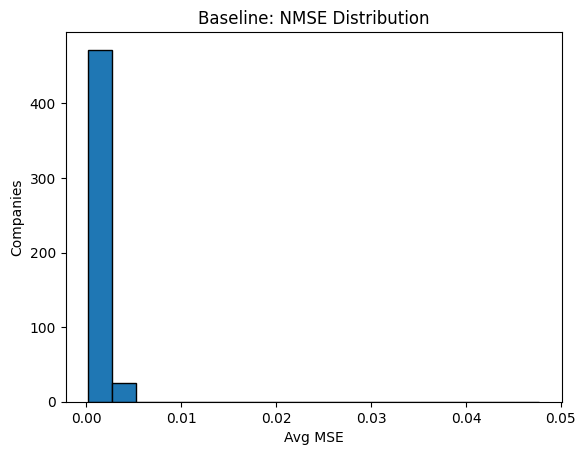

In [ ]:
#Make a histogram of performance
b_mse_avg_data = average_baseline_mse_df['Average MSE']
b_mse_avg_data = np.clip(b_mse_avg_data, 0, 0.05)
bins = np.arange(start=min(b_mse_avg_data), stop=0.05, step=0.0025)  # Adjust step for finer or coarser bins
#bins = np.append(bins, np.max(b_mse_avg_data))

plt.hist(b_mse_avg_data, bins=bins, edgecolor='black')
plt.title('Baseline: NMSE Distribution')
plt.xlabel('Avg MSE')
plt.ylabel('Companies')

# Displaying the histogram
plt.show()

In [ ]:
#Determine how many stocks the LSTM performs better for
better = 0

for i in range(1, len(mse_avg_data)):
  if mse_avg_data[i] < b_mse_avg_data[i]:
    better += 1

print(better)

14


## Compare MAE to Baseline

In [ ]:
#Calc Average Baseline MAE
mean_baseline_mae = baseline_mae_df.mean()
average_baseline_mae_df = mean_baseline_mae.to_frame(name='Baseline MAE')
# Reset the index to make the stock names a column
average_baseline_mae_df.reset_index(inplace=True)
average_baseline_mae_df.rename(columns={'index': 'Stock'}, inplace=True)

<ipython-input-111-f7f911ea12ec>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_baseline_mae = baseline_mae_df.mean()


In [ ]:
#Calc Average LSTM MAE
mean_mae = mae_df.mean()
average_mae_df = mean_mae.to_frame(name='Predicted MAE')
average_mae_df.reset_index(inplace=True)
average_mae_df.rename(columns={'index': 'Stock'}, inplace=True)

<ipython-input-112-fb06e29791ef>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_mae = mae_df.mean()


In [ ]:
#Join the DFs
average_mae_df = average_mae_df.merge(average_baseline_mae_df, on='Stock')

In [ ]:
#Calc difference
average_mae_df['Dif'] = average_mae_df['Predicted MAE'] - average_mae_df['Baseline MAE']

In [ ]:
#Determine how many are negative (baseline performs better)
average_mae_df['Negative Dif'] = average_mae_df['Dif'] < 0
average_mae_df['Negative Dif'].sum()

1

## Mean Directional Error in 2024

In [ ]:
avg_mde = directional_error_df.mean()
average_mde_df = avg_mde.to_frame(name='Average MDE')

# Reset the index to make the stock names a column
average_mde_df.reset_index(inplace=True)
average_mde_df.rename(columns={'index': 'Stock'}, inplace=True)

<ipython-input-116-d81cd05e0a0b>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_mde = directional_error_df.mean()


In [ ]:
#Average across all stocks
average_mde_df['Average MDE'].mean()

0.4907089596401941

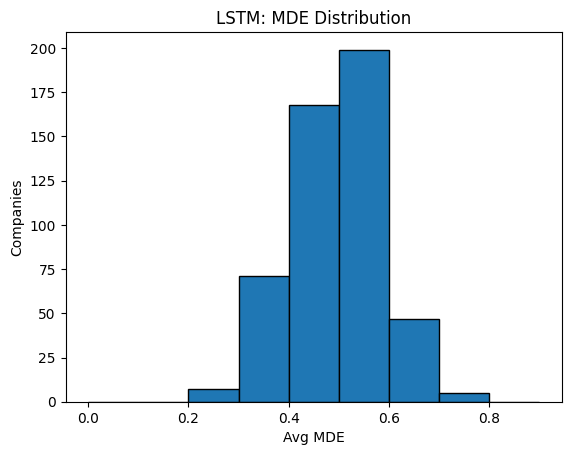

In [ ]:
#Make Histogram
b_mde_avg_data = average_mde_df['Average MDE']
bins = np.arange(start=0, stop=1, step=0.1)  # Adjust step for finer or coarser bins
#bins = np.append(bins, np.max(b_mse_avg_data))

plt.hist(b_mde_avg_data, bins=bins, edgecolor='black')
plt.title('LSTM: MDE Distribution')
plt.xlabel('Avg MDE')
plt.ylabel('Companies')

# Displaying the histogram
plt.show()

# Garch Model Evaluation

In [ ]:
df = pd.read_csv("/content/drive/My Drive/HODL_Project/closing_prices.csv")
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df

,Date,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,2022-02-22 05:00:00+00:00,131.848373,66.999771,113.157043,134.771225,311.504822,438.399994,115.650002,19.725672,59.775093,...,26.563948,216.682327,461.913452,87.652527,62.030247,87.747414,119.439003,409.760010,117.489258,186.885986
1,2022-02-23 05:00:00+00:00,129.719040,65.419464,112.906662,135.882248,303.792664,429.450012,109.760002,19.293791,58.651398,...,27.113052,210.488632,452.326752,86.306313,61.080128,85.934158,117.051567,399.290009,117.116631,183.897400
2,2022-02-24 05:00:00+00:00,129.108078,65.303825,114.322220,134.502716,306.712646,463.820007,116.610001,19.641172,56.775391,...,26.969023,213.391327,456.132111,85.603516,60.986065,85.495468,116.830154,415.329987,117.976532,187.721619
3,2022-02-25 05:00:00+00:00,135.226562,66.864868,117.875534,138.456207,312.862976,465.540009,121.059998,19.819557,58.994221,...,27.626146,217.099777,466.335144,86.880432,63.243763,88.644272,119.102074,418.070007,121.053017,191.418060
4,2022-02-28 05:00:00+00:00,133.555435,66.084343,116.151833,136.817413,306.567108,467.679993,123.339996,19.932224,58.175251,...,28.157246,215.808609,466.677490,85.643105,63.337833,86.714043,118.004616,413.339996,121.521172,190.375961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-14 05:00:00+00:00,90.909996,81.169998,112.059998,174.419998,370.980011,604.659973,178.699997,16.139999,78.422897,...,33.049999,275.160004,944.400024,104.961227,58.680000,123.798927,133.342682,252.960007,121.839996,184.080002
498,2024-02-15 05:00:00+00:00,92.379997,81.000000,113.639999,176.589996,371.510010,590.440002,176.759995,16.780001,79.665024,...,34.189999,277.440002,943.690002,105.480003,59.009998,124.058167,134.725769,283.750000,124.400002,189.649994
499,2024-02-16 05:00:00+00:00,91.250000,80.089996,114.010002,177.490005,369.480011,546.659973,173.869995,16.770000,78.879997,...,34.310001,277.309998,935.799988,105.129997,59.070000,123.430000,133.880005,275.459991,124.709999,188.389999
500,2024-02-20 05:00:00+00:00,91.820000,79.639999,116.639999,175.750000,362.950012,541.909973,165.690002,16.420000,78.779999,...,34.110001,275.640015,935.150024,103.230003,59.189999,124.099998,133.949997,271.929993,124.980003,186.550003


In [ ]:
series0 = df[(df['Date'].dt.year == 2023) | (df['Date'].dt.year == 2022)]
#467(2022-02-22 to 2023-12-29) * 498(Date + 497 Stocks)

df_2024 = df[df['Date'].dt.year == 2024]
#35 rows(index:467-501, 2024-01-02 to 2024-02-21) × 498 columns

In [ ]:
date_range = df[df['Date'] >= '2024-01-02']['Date']
date_range = date_range.tolist()
len(date_range)

35

#### Initialize dataframes for storing predicted prices, MSEs, and volatilities (only run once)

In [ ]:
stock_names = list(df.columns)[1:]
num_rows = 36

preds_df = pd.DataFrame(columns=['Date'])
preds_df['Date'] = date_range
mse_df = pd.DataFrame(columns=['Date'])
mse_df['Date'] = date_range
volatility_df = pd.DataFrame(columns=['Date'])
volatility_df['Date'] = date_range

for stock_name in stock_names:
    preds_df[stock_name] = [None] * (num_rows-1)
    mse_df[stock_name] = [None] * (num_rows-1)
    volatility_df[stock_name] = [None] * (num_rows-1)
#35 rows × 498 columns

# Save the initialized DataFrames to CSV files (only run once)
#preds_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/garch_preds.csv', index=False)
#mse_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/garch_mse.csv', index=False)
#volatility_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/garch_volatility.csv', index=False)

<ipython-input-128-86e7cb8c5bd2>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  preds_df[stock_name] = [None] * (num_rows-1)
<ipython-input-128-86e7cb8c5bd2>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mse_df[stock_name] = [None] * (num_rows-1)
<ipython-input-128-86e7cb8c5bd2>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

#### Calculate log returns
shifts all the values in the DataFrame df except for the first column (iloc[:, 1:]) down by one row.


*   Each value in the DataFrame is moved down by one row.
*  The first row becomes NaN (missing value) because there's no value to shift into its place.
*   The last row is discarded because it's shifted out of the DataFrame's range.


In [ ]:
def log_returns(df):
  #skip the 0th col (the Date col), subset from the 1st col
  log_returns = np.log(df.iloc[:, 1:] / df.iloc[:, 1:].shift(1))
  log_returns = log_returns.dropna()
  return log_returns

### For all stocks from 2024-01-02 to 2024-02-21

In [ ]:
preds_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_preds.csv")
mse_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_mse.csv")
volatility_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_volatility.csv")

In [ ]:
#base_save_path = '/content/drive/My Drive/HODL_Project/Updated_GARCH/'
for stock in range(0, 497):
  mse_column = []  #list to store MSE values for the current stock
  next_day_price_pred_column = []  #list to store next day price predictions for the current stock
  volatility_column = []
  for time in range(0, 35):
    #when time=0: initial models
    series_df = pd.concat([series0, df_2024.head(time)])
    series_log_returns = log_returns(series_df).iloc[:,stock]

    # Fit a GARCH(1,1) model
    #uses the most recent observation and the previous observation to calculate the conditional variance at each time step.
    #effective rolling window size is 2.
    model = arch_model(series_log_returns, vol='Garch', p=1, q=1, mean='constant', dist='Normal', rescale=False)
    results = model.fit(disp='off')

    ###########################################################################
    # Predict the next day's returns
    pred_returns = results.forecast(horizon=1).mean.iloc[-1].values[0]

    # extract the last available/known price
    last_available_price = series_df.iloc[-1,stock+1]

    # Use the last available price to predict the next day's price
    next_day_price_pred = last_available_price * np.exp(pred_returns)
    next_day_price_pred_column.append(next_day_price_pred)

    # Calculate mean squared error (MSE) for price prediction
    actual_next_day_price = df_2024.iloc[time,stock+1]
    price_mse = (next_day_price_pred - actual_next_day_price) ** 2
    mse_column.append(price_mse)
    ###########################################################################
    # Extract the forecasted conditional variance
    forecasted_conditional_variance = results.forecast(horizon=1).variance.iloc[-1]
    # Calculate volatility as the square root of conditional variance
    volatility = np.sqrt(forecasted_conditional_variance)
    volatility_column.append(volatility)
    ###########################################################################
    # # Construct the save path for the model
    # model_save_path = os.path.join(base_save_path, f'garch_model_stock{stock+1}_day{time+1}.pkl')

    # # Save the model using pickle
    # with open(model_save_path, 'wb') as f:
    #     pickle.dump(results, f)

    # print(f"Model saved to {model_save_path}")
    ###########################################################################
    #print(f'Stock{stock+1}_Day{time+1}')

  # Add the next day price predictions and MSE values to the corresponding cells in the DataFrames
  preds_df.iloc[:, stock+1] = next_day_price_pred_column
  mse_df.iloc[:, stock+1] = mse_column
  volatility_df.iloc[:, stock+1] = volatility_column
  print(f'Stock{stock+1}')

# Save the updated DataFrames back to the CSV files
#preds_df.to_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_preds.csv", index=False)
#mse_df.to_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_mse.csv", index=False)
#volatility_df.to_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_volatility.csv", index=False)

Stock1
Stock2
Stock3
Stock4
Stock5
Stock6
Stock7
Stock8
Stock9
Stock10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock11
Stock12
Stock13
Stock14
Stock15
Stock16
Stock17
Stock18
Stock19
Stock20
Stock21
Stock22
Stock23
Stock24
Stock25
Stock26
Stock27
Stock28
Stock29
Stock30
Stock31
Stock32
Stock33
Stock34
Stock35
Stock36
Stock37
Stock38
Stock39
Stock40
Stock41
Stock42
Stock43


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock44
Stock45
Stock46
Stock47
Stock48
Stock49
Stock50
Stock51
Stock52
Stock53
Stock54
Stock55
Stock56
Stock57
Stock58
Stock59
Stock60
Stock61


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock62
Stock63
Stock64
Stock65
Stock66
Stock67
Stock68
Stock69
Stock70
Stock71


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock72
Stock73
Stock74
Stock75
Stock76
Stock77
Stock78
Stock79
Stock80
Stock81
Stock82
Stock83
Stock84
Stock85
Stock86
Stock87
Stock88
Stock89
Stock90
Stock91
Stock92
Stock93
Stock94


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock95
Stock96
Stock97
Stock98
Stock99
Stock100
Stock101
Stock102
Stock103
Stock104
Stock105
Stock106


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock107
Stock108
Stock109
Stock110
Stock111
Stock112
Stock113
Stock114
Stock115
Stock116
Stock117
Stock118
Stock119
Stock120
Stock121
Stock122
Stock123
Stock124
Stock125
Stock126
Stock127
Stock128
Stock129
Stock130
Stock131
Stock132
Stock133
Stock134
Stock135
Stock136
Stock137
Stock138
Stock139
Stock140
Stock141
Stock142
Stock143
Stock144
Stock145
Stock146
Stock147
Stock148
Stock149
Stock150
Stock151
Stock152
Stock153
Stock154
Stock155
Stock156
Stock157
Stock158
Stock159
Stock160
Stock161
Stock162
Stock163
Stock164
Stock165
Stock166
Stock167
Stock168
Stock169
Stock170
Stock171
Stock172
Stock173
Stock174
Stock175
Stock176
Stock177
Stock178
Stock179
Stock180
Stock181
Stock182
Stock183
Stock184
Stock185
Stock186
Stock187
Stock188
Stock189
Stock190
Stock191
Stock192
Stock193
Stock194
Stock195
Stock196
Stock197
Stock198
Stock199
Stock200
Stock201
Stock202
Stock203
Stock204
Stock205
Stock206
Stock207
Stock208
Stock209
Stock210
Stock211
Stock212
Stock213
Stock214
Stock215
Stock216
Stock217
S

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock220
Stock221
Stock222
Stock223
Stock224
Stock225
Stock226
Stock227
Stock228
Stock229
Stock230
Stock231
Stock232
Stock233
Stock234
Stock235
Stock236
Stock237
Stock238
Stock239
Stock240
Stock241
Stock242
Stock243
Stock244
Stock245
Stock246
Stock247
Stock248
Stock249
Stock250
Stock251
Stock252
Stock253
Stock254
Stock255
Stock256
Stock257
Stock258
Stock259
Stock260
Stock261
Stock262
Stock263
Stock264
Stock265
Stock266
Stock267
Stock268
Stock269
Stock270
Stock271


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock272
Stock273
Stock274
Stock275
Stock276
Stock277
Stock278
Stock279
Stock280
Stock281
Stock282
Stock283
Stock284
Stock285
Stock286
Stock287
Stock288
Stock289
Stock290
Stock291
Stock292


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock293
Stock294
Stock295
Stock296
Stock297
Stock298
Stock299
Stock300
Stock301
Stock302
Stock303
Stock304
Stock305
Stock306
Stock307
Stock308
Stock309
Stock310
Stock311
Stock312
Stock313
Stock314
Stock315
Stock316
Stock317
Stock318
Stock319
Stock320
Stock321
Stock322
Stock323
Stock324
Stock325
Stock326
Stock327
Stock328


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock329
Stock330
Stock331
Stock332
Stock333
Stock334
Stock335
Stock336
Stock337
Stock338
Stock339
Stock340
Stock341
Stock342
Stock343
Stock344
Stock345
Stock346
Stock347
Stock348
Stock349
Stock350
Stock351
Stock352
Stock353
Stock354
Stock355
Stock356
Stock357
Stock358
Stock359
Stock360
Stock361
Stock362
Stock363
Stock364
Stock365
Stock366
Stock367
Stock368
Stock369
Stock370
Stock371
Stock372
Stock373
Stock374
Stock375
Stock376
Stock377
Stock378
Stock379
Stock380
Stock381
Stock382
Stock383
Stock384
Stock385
Stock386
Stock387
Stock388
Stock389
Stock390
Stock391
Stock392
Stock393
Stock394
Stock395
Stock396
Stock397
Stock398
Stock399
Stock400


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock401
Stock402
Stock403
Stock404
Stock405
Stock406
Stock407
Stock408
Stock409
Stock410
Stock411
Stock412
Stock413


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock414
Stock415
Stock416
Stock417
Stock418
Stock419
Stock420
Stock421
Stock422
Stock423
Stock424
Stock425
Stock426
Stock427
Stock428
Stock429
Stock430
Stock431
Stock432
Stock433
Stock434
Stock435
Stock436
Stock437
Stock438
Stock439
Stock440
Stock441
Stock442
Stock443
Stock444
Stock445
Stock446
Stock447
Stock448
Stock449
Stock450
Stock451
Stock452
Stock453
Stock454
Stock455
Stock456
Stock457
Stock458
Stock459
Stock460
Stock461
Stock462
Stock463
Stock464
Stock465
Stock466
Stock467
Stock468
Stock469
Stock470
Stock471
Stock472
Stock473
Stock474
Stock475
Stock476
Stock477
Stock478
Stock479
Stock480
Stock481
Stock482
Stock483
Stock484
Stock485
Stock486
Stock487
Stock488


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Stock489
Stock490
Stock491
Stock492
Stock493
Stock494
Stock495
Stock496
Stock497


^^

Takes ~15min to run with model model saving

Takes ~7min to run without model saving

### Plots - predicted vs. actual price

In [ ]:
preds_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_preds.csv")

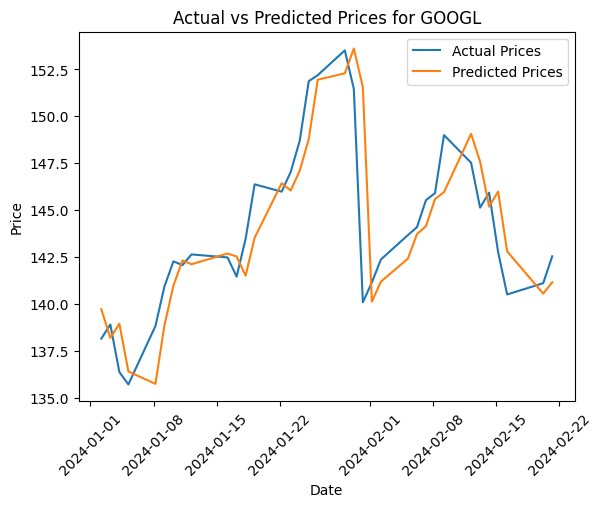

In [ ]:
# GOOGL
actual_prices = df_2024['GOOGL'].tolist()
predicted_prices = preds_df['GOOGL'].tolist()
dates = date_range

dates = pd.to_datetime(dates)

plt.plot(dates, actual_prices, label='Actual Prices')
plt.plot(dates, predicted_prices, label='Predicted Prices')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices for GOOGL')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

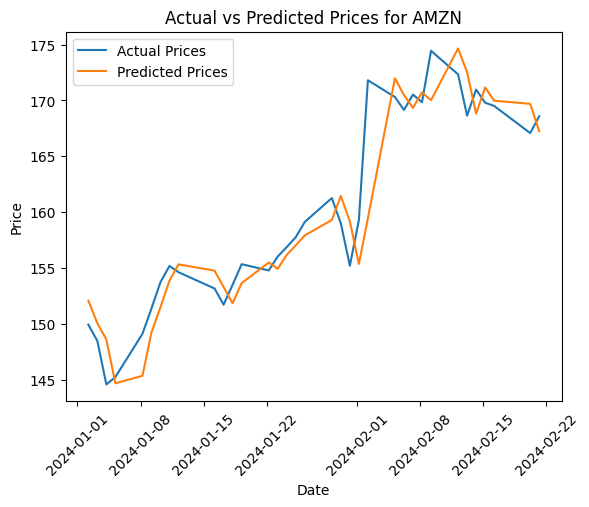

In [ ]:
# AMZN
actual_prices = df_2024['AMZN'].tolist()
predicted_prices = preds_df['AMZN'].tolist()
dates = date_range

dates = pd.to_datetime(dates)

plt.plot(dates, actual_prices, label='Actual Prices')
plt.plot(dates, predicted_prices, label='Predicted Prices')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices for AMZN')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

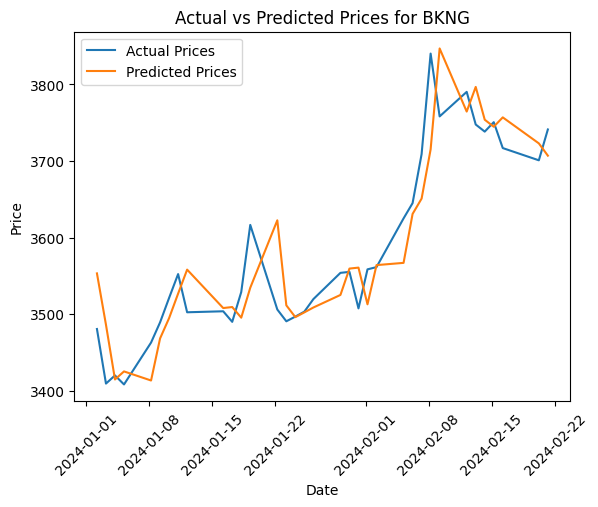

In [ ]:
# BKNG
actual_prices = df_2024['BKNG'].tolist()
predicted_prices = preds_df['BKNG'].tolist()
dates = date_range

dates = pd.to_datetime(dates)

plt.plot(dates, actual_prices, label='Actual Prices')
plt.plot(dates, predicted_prices, label='Predicted Prices')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices for BKNG')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

### Plots - predicted vs. actual volatility
Volatility: measure of the amount of uncertainty or risk involved in the size of changes in a stock's value.

* Calculate actual volatility (in 2024) from the historical closing prices data

  * uses the most recent observation and the previous observation to calculate the conditional variance

  * effective rolling window size = 2

In [ ]:
#subset historical closing prices to start from one day before the first day in 2024
closing_prices_2024 = pd.concat([series0.tail(2), df_2024], ignore_index=True)

#(don't need to drop the first "Date" col because the log_returns(df) function handles that)

#calculate log returns (using function defined earlier)
calculated_log_returns = log_returns(closing_prices_2024)

# Calculate rolling variance of log returns using only previous day info
rolling_variance = calculated_log_returns.rolling(window=2).var()

# Calculate volatility as the square root of rolling variance
actual_volatility = np.sqrt(rolling_variance)

In [ ]:
#drop the first row which becomes NaNs after calculating the log_returns
actual_volatility = actual_volatility.dropna()

# Add a new row at the end with NaN values (referring to the volatility on the last day)
#actual_volatility.loc[len(actual_volatility)] = [np.nan] * len(actual_volatility.columns)

# Insert the "Date" column at the beginning of the DataFrame
actual_volatility.insert(0, "Date", date_range)

#actual_volatility.to_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_actual_volatility.csv", index=False)

In [ ]:
volatility_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_volatility.csv")
actual_volatility = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_actual_volatility.csv")

date_range = df[df['Date'] >= '2024-01-02']['Date']
date_range = date_range.tolist()

dates = date_range
dates = pd.to_datetime(dates)

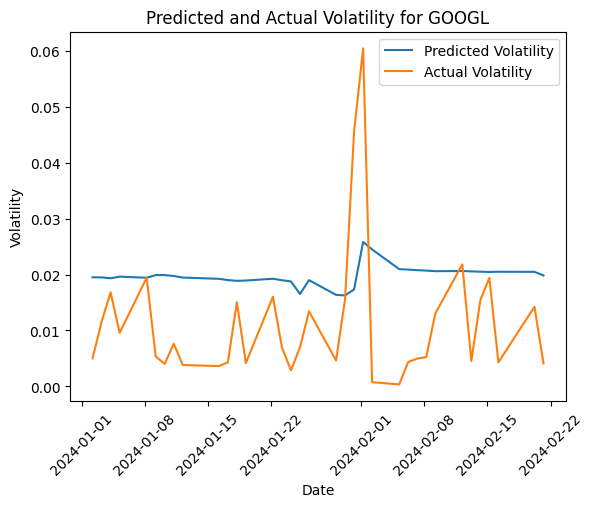

In [ ]:
# GOOGL
pred_vol = volatility_df['GOOGL'].tolist()
actual_vol = actual_volatility['GOOGL'].tolist()

plt.plot(dates, pred_vol, label='Predicted Volatility')
plt.plot(dates, actual_vol, label='Actual Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Predicted and Actual Volatility for GOOGL')
plt.xticks(rotation=45)
plt.legend()
plt.show()

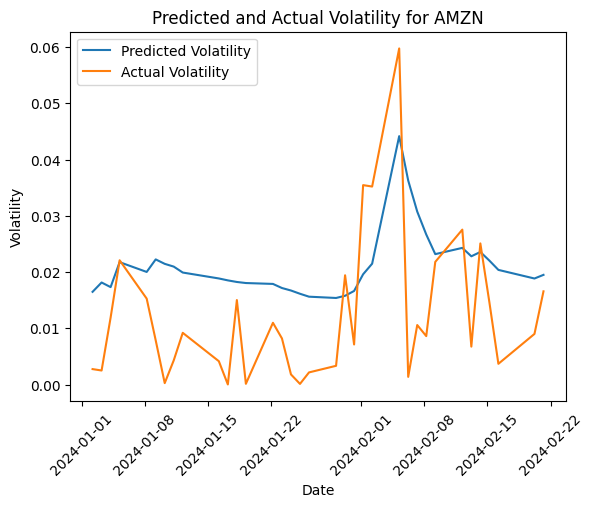

In [ ]:
# AMZN
pred_vol_amzn = volatility_df['AMZN'].tolist()
actual_vol_amzn = actual_volatility['AMZN'].tolist()

plt.plot(dates, pred_vol_amzn, label='Predicted Volatility')
plt.plot(dates, actual_vol_amzn, label='Actual Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Predicted and Actual Volatility for AMZN')
plt.xticks(rotation=45)
plt.legend()
plt.show()

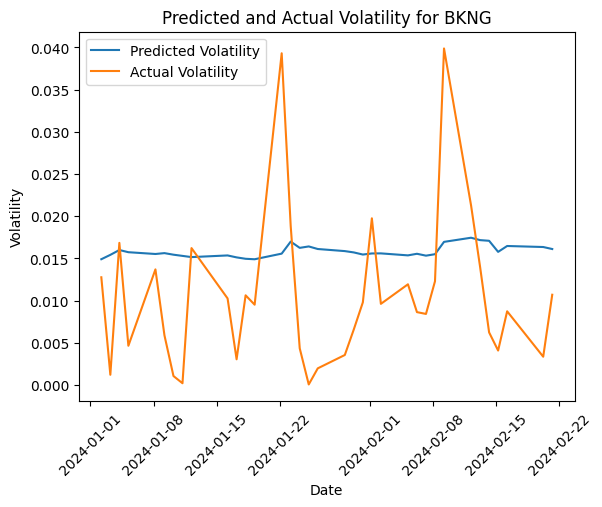

In [ ]:
# BKNG
pred_vol_bkng = volatility_df['BKNG'].tolist()
actual_vol_bkng = actual_volatility['BKNG'].tolist()

plt.plot(dates, pred_vol_bkng, label='Predicted Volatility')
plt.plot(dates, actual_vol_bkng, label='Actual Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Predicted and Actual Volatility for BKNG')
plt.xticks(rotation=45)
plt.legend()
plt.show()

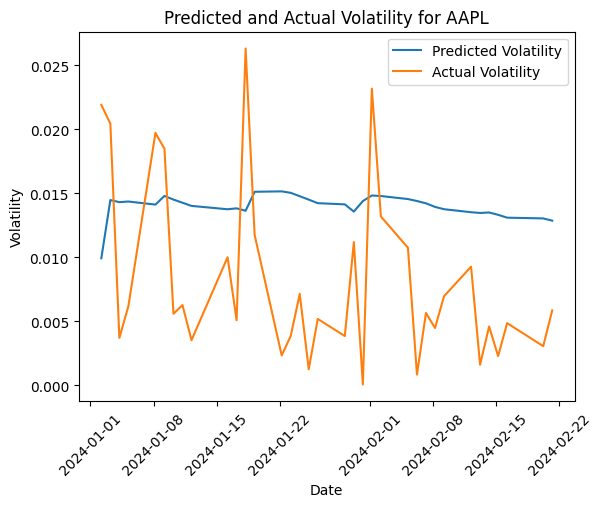

In [ ]:
# AAPL
pred_vol_aapl = volatility_df['AAPL'].tolist()
actual_vol_aapl = actual_volatility['AAPL'].tolist()

plt.plot(dates, pred_vol_aapl, label='Predicted Volatility')
plt.plot(dates, actual_vol_aapl, label='Actual Volatility')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Predicted and Actual Volatility for AAPL')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Output for Agent

## Get Company Names (Wikipedia)

In [ ]:
#Function to Get company name
def fetch_sp500_info():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)  # This parses all the tables in webpages
    sp500_table = tables[0]  # Assuming the first table is the S&P 500 list
    sp500_table = sp500_table[['Symbol', 'Security']]  # Adjust column name if necessary
    return sp500_table

In [ ]:
#Save company name in a table
sp500_table = fetch_sp500_info()

## Make sure all data is present

In [ ]:
#Read in all data (if needed)
prices_df = pd.read_csv("/content/drive/My Drive/HODL_Project/closing_prices.csv")
actual_vol_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_actual_volatility.csv")
pred_vol_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/garch_volatility.csv")
preds_df = pd.read_csv("/content/drive/My Drive/HODL_Project/Prediction_DF/preds.csv")
delta_df = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/delta_df.csv')
rolling_mde_7day = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/rolling_mde_7day.csv')
delta_perc_df = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/delta_perc_df.csv')
rolling_mae_7day = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/rolling_mae_7day.csv')

## Calc Garch Model % Change

In [ ]:
#Change in Volitility DF - Actual starts 1/2, pred starts 1/3
#Check calculation is right
perc_change_pred_vol_df = pd.DataFrame(data=date_range[1:], columns = ['Date'])

for j in range(1, pred_vol_df.shape[1]):
  vol_change_list = []
  for i in range(0, pred_vol_df.shape[0]-1):
    val = (pred_vol_df.iloc[i+1,j] - actual_vol_df.iloc[i,j]) / actual_vol_df.iloc[i,j]
    vol_change_list.append(val)
  col = pd.DataFrame(vol_change_list)
  perc_change_pred_vol_df = pd.concat([perc_change_pred_vol_df, col], axis=1)

perc_change_pred_vol_df.columns = prices_df_cols

<ipython-input-205-c630c6cfd6f9>:8: RuntimeWarning: divide by zero encountered in scalar divide
  val = (pred_vol_df.iloc[i+1,j] - actual_vol_df.iloc[i,j]) / actual_vol_df.iloc[i,j]


## Extract Relevant Rows from DFs

In [ ]:
#Get Last Day Predictions

#Last actual - 2 days before:
last_price = prices_df.iloc[-2,1:]
last_actual_vol = actual_vol_df.iloc[-2,1:]

#Preds - Last Row
next_pred = preds_df.iloc[-1,1:]
last_pred_vol = pred_vol_df.iloc[-1,1:]

#Change - Last Row
last_pred_change = delta_df.iloc[-1,1:]
last_pred_change_perc = delta_perc_df.iloc[-1,1:]
last_perc_vol_perc = perc_change_pred_vol_df.iloc[-1,1:]  * 100

#Rolling Errors - Last Row based on code design (excludes the day itself)
last_avg_mse = rolling_mae_7day.iloc[-1,1:]
last_avg_mde = rolling_mde_7day.iloc[-1,1:]

## Make DF

In [ ]:
### May need to update based on Yutong's Code #####
#Make Dictionary
output_df = {'Ticker' : prices_df_cols[1:],
             'current_price': last_price,
             'forecasted_price' : next_pred,
             'forecasted_price_change':last_pred_change,
             'percent_change': last_pred_change_perc * 100,
             'current_volatility': last_actual_vol,
             'forecasted_volatility': last_pred_vol,
             'forecasted_volatility_change': last_perc_vol_perc,
             'model_error_last_week' : last_avg_mse,
             'model_mda_last_week':last_avg_mde}

#Make DF
output_df = pd.DataFrame(data=output_df)

In [ ]:
#Join with SP500 table for company name
output_df = output_df.merge(sp500_table, left_on='Ticker', right_on = 'Symbol', how='left')

In [ ]:
#Reorder cols so company name is second
cols = list(output_df.columns)
new_order = [cols[0]] + [cols[-1]] + cols[1:-1]
output_df = output_df[new_order]
output_df.head()

,Ticker,Security,current_price,forecasted_price,forecasted_price_change,percent_change,current_volatility,forecasted_volatility,forecasted_volatility_change,model_error_last_week,model_mda_last_week,Symbol
0,MMM,3M,91.82,93.31629,1.49629,1.62959,0.013106,0.017696,35.021183,2.013992,42.857143,MMM
1,AOS,A. O. Smith,79.639999,74.805051,-4.834948,-6.071004,0.004005,0.01571,292.265281,6.112759,57.142857,AOS
2,ABT,Abbott,116.639999,110.861474,-5.778526,-4.954154,0.013828,0.01342,-2.950304,3.130089,28.571429,ABT
3,ABBV,AbbVie,175.75,172.133345,-3.616655,-2.057841,0.010561,0.012887,22.028999,3.335456,57.142857,ABBV
4,ACN,Accenture,362.950012,367.506187,4.556174,1.255317,0.008734,0.013545,55.075431,9.132794,57.142857,ACN


In [ ]:
output_df = output_df.drop(columns=['Symbol'])
output_df = output_df.rename(columns={'Security': 'Stock'})

In [ ]:
output_df['Ticker'] = output_df['Ticker'].str.lower()
output_df['Stock'] = output_df['Stock'].str.lower()
output_df.tail()

,Ticker,Stock,current_price,forecasted_price,forecasted_price_change,percent_change,current_volatility,forecasted_volatility,forecasted_volatility_change,model_error_last_week,model_mda_last_week
492,xyl,xylem inc.,124.099998,111.671234,-12.428764,-10.015121,0.007417,0.015811,113.160105,11.177481,42.857143
493,yum,yum! brands,133.949997,128.791188,-5.158809,-3.851295,0.004823,0.010888,125.77327,4.283292,42.857143
494,zbra,zebra technologies,271.929993,261.986836,-9.943157,-3.656513,0.011846,0.028328,139.128409,11.883679,42.857143
495,zbh,zimmer biomet,124.980003,120.568625,-4.411378,-3.529667,0.000231,0.014593,6228.137813,2.632496,42.857143
496,zts,zoetis,186.550003,181.352402,-5.197601,-2.78617,0.002227,0.017044,665.448184,8.76938,85.714286


In [ ]:
#Save Output
output_df.to_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/output_df.csv', index=False)

# Slot Filing

Link to Github: xxx

In [ ]:
# Download the "HODL" library
!wget -q 'https://www.dropbox.com/s/4rdgil1epnvgitf/HODL.py'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

import tensorflow as tf
from tensorflow import keras

from HODL import TransformerEncoder, PositionalEmbedding

##################### CONSTANTS #####################
keras.utils.set_random_seed(2024)
MAX_QUERY_LENGTH = 50  #size of input
EMBED_DIM = 512  #dimension of embeddings
DENSE_DIM = 128
NUM_HEADS = 8  #number of multi-attention heads
DENSE_UNITS = 128  #num nodes in hidden layer
BATCH_SIZE = 64  #batch size for training transformer
EPOCHS = 10  #epochs for training transformer

# Read training data
test_df = pd.read_csv("/content/drive/My Drive/HODL_Project/testing_data.csv")
train_df = pd.read_csv("/content/drive/My Drive/HODL_Project/training_data.csv")

train_query = train_df['query'].values
train_slotfilling = train_df['slot filling'].values
test_query = test_df['query'].values
test_slotfilling = test_df['slot filling'].values
#####################################################

# CREATE VECTORIZER (QUERY & SLOTS)
vectorize_query_text = keras.layers.TextVectorization(
    max_tokens=None,  #no maximum vocabulary
    output_sequence_length=MAX_QUERY_LENGTH,  #pad or truncate output to value
    output_mode="int",  #vector has index of vocabulary
    standardize="lower_and_strip_punctuation",  #convert input to lowercase and rmv punctuation
    split="whitespace",  #split values based on whitespace
    ngrams=1  #only look at whole words
)
vectorize_slot_text = keras.layers.TextVectorization(
    max_tokens=None,  #no maximum vocabulary
    output_sequence_length=MAX_QUERY_LENGTH,
    output_mode="int",  #vector has index of vocabulary
    standardize="lower",  #convert input to lowercase [can't do punctuation b/c of dashes]
    split="whitespace",  #split values based on whitespace
    ngrams=1  #only look at whole words
)

# CREATE VOCABULARY AND VECTORIZED TRAINING DATA
vectorize_query_text.adapt(train_query)  #build vocabulary
query_train = vectorize_query_text(train_query)  #vectorized training queries
query_test = vectorize_query_text(test_query)  #vectorized testing queries
QUERY_VOCAB_SIZE = vectorize_query_text.vocabulary_size() #total vocabulary of queries

vectorize_slot_text.adapt(train_slotfilling)  #build slot vocabulary
slots_train = vectorize_slot_text(train_slotfilling)  #vectorized training slots
slots_test = vectorize_slot_text(test_slotfilling)  #vectorized testing slots
SLOT_VOCAB_SIZE = vectorize_slot_text.vocabulary_size()  #total vocabulary of slots

# BUILD KERAS MODEL
inputs = keras.Input(shape=(MAX_QUERY_LENGTH,))
embedding = PositionalEmbedding(MAX_QUERY_LENGTH,
                                QUERY_VOCAB_SIZE,
                                EMBED_DIM)
x = embedding(inputs)
encoder_out = TransformerEncoder(EMBED_DIM,
                                 DENSE_DIM,
                                 NUM_HEADS)(x)
x = keras.layers.Dense(DENSE_UNITS, activation="relu", name="Dense_Layer")(encoder_out)
x = keras.layers.Dropout(0.25, name="Dropout_Layer")(x)
outputs = keras.layers.Dense(SLOT_VOCAB_SIZE, activation="softmax", name="Softmax_Layer")(x)

model = keras.Model(inputs, outputs)
print()
print(model.summary())
print()

# TRAIN KERAS MODEL
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])
history = model.fit(query_train, slots_train,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS)

# OUT-OF-SAMPLE TESTING
model.evaluate(query_test, slots_test)

# SAVE MODEL
filename = '/content/drive/My Drive/HODL_Project/sql_transformer.keras'
model.save(filename)
ZipFile('/content/drive/My Drive/HODL_Project/model_save.zip', mode='w').write(filename)

# EVALUATING SLOT ACCURACY
def slot_filling_accuracy(actual, predicted, only_slots=False):
    not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

    if only_slots:
        non_slot_token = vectorize_slot_text(['O']).numpy()[0, 0]
        slots = np.not_equal(actual, non_slot_token)
        correct_predictions = np.equal(actual, predicted)[not_padding * slots]
    else:
        correct_predictions = np.equal(actual, predicted)[not_padding]

    sample_length = len(correct_predictions)

    weights = np.ones(sample_length)

    return np.dot(correct_predictions, weights) / sample_length

predicted = np.argmax(model.predict(query_test), axis=-1).reshape(-1)
actual = slots_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy = {acc:.3f}')
print(f'Accuracy on slots = {acc_slots:.3f}')

# TEST-SET EVALUATION
def predict_slots_query(query, model, query_vectorizer, slot_vectorizer):
    sentence = query_vectorizer([query])

    prediction = np.argmax(model.predict(sentence), axis=-1)[0]

    inverse_vocab = dict(enumerate(slot_vectorizer.get_vocabulary()))
    decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
    return decoded_prediction

for example, answer in zip(test_query, test_slotfilling):
    print()
    print("Query:\n", example)
    print("Answer:\n", answer)
    print("Prediction:\n", predict_slots_query(example,
                                               model,
                                               vectorize_query_text,
                                               vectorize_slot_text))
    print()

## Slot Parser Function

In [ ]:
def SlotParser(slot_filling, prompt, stock_data):
    slot_filling = slot_filling.strip()  #strip any whitespace from slot_filling return
    # initialize aspects of the SQL query
    slots = {'select': [],
             'order': [],
             'limit': None}

    # for word (token) in prompt
    for word in prompt.split(" "):
        if word.isnumeric():  #if we found a number
            slots['limit'] = int(word)  #assume number relates to LIMIT (# of rows to display)

    # for slot (token) in output
    for token in slot_filling.split(" "):
        if (token != "o") and (token != "O"):  #if not a null slot
            if 'select-' in token:  #if a select slot
                if token not in slots['select']:  #if we haven't already added it
                    slots['select'].append(token)  #then include in SELECT statement
            elif 'order-by' in token:  #if an order-by slot
                if token not in slots['order']:  #if we haven't already added it
                    slots['order'].append(token)  #then include in ORDER BY statement

    if len(slots['select']) == 0:  #if we haven't selected a colummn
        columns = list(stock_data.columns)  #assume all
    else:  #if we have selected >= 1 column
        columns = [x.split("-")[1] for x in slots['select']]  #access column names, format them

    if len(slots['order']) == 0:  #if we haven't ordered a column
        if 'stock' not in columns:
            columns.insert(0, 'stock')  #insert at beginning
        order_cols = ['stock']  #assume we order by stock
        order_ascending = [True]  #assum ascending order
    else:  #if there is order statement
        order_cols = [x.split("-")[2] for x in slots['order']]  #format
        order_ascending = [True if x.split("-")[-1] == 'asc' else False for x in slots['order']]  #format

    if slots['limit'] == None:  #if we don't have a number
        limit = len(stock_data)  #assume we want all rows
    else:  #if there is a limit number
        limit = int(slots['limit'])  #make sure to return that many rows

    for col in order_cols:  #for every ordering column
        if col not in columns:  #check if it is an accessible column
            columns.append(col)  #if not, add it

    pandas_query = stock_data[columns]  #use only selected columns
    pandas_query = pandas_query.sort_values(by=order_cols,  #columns to sort
                                            ascending=order_ascending,  #boolean list of asc/desc
                                            ignore_index=True)
    pandas_query = pandas_query.head(limit)  #LIMIT statement

    all_data = stock_data.sort_values(by=order_cols,
                                      ascending=order_ascending,
                                      ignore_index=True)  #include just in case
    # print(pandas_query)  #print the dataframe

    #formatting SQL statements
    SELECT = f"SELECT {', '.join(columns)}"
    FROM = "FROM stock_data"
    ORDER_BY = f"ORDER BY {', '.join((str(x.split('-')[2])+' '+str(x.split('-')[-1].upper())) for x in slots['order'])}"
    LIMIT = f"LIMIT {slots['limit']}"

    #checking for errors
    if len(slots['select']) == 0:  #empty slots
        SQL_QUERY = "SELECT *\n FROM stock_data"
    elif (len(slots['order']) == 0) and (slots['limit'] == None):  #no sort or limit statement
        SQL_QUERY = f"{SELECT}\n{FROM}"
    elif len(slots['order']) == 0:  #no order clause
        SQL_QUERY = f"{SELECT}\n{FROM}\n{LIMIT}"
    elif slots['limit'] == None:  #no limit clause
        SQL_QUERY = f"{SELECT}\n{FROM}\n{ORDER_BY}"
    else:
        SQL_QUERY = f"{SELECT}\n{FROM}\n{ORDER_BY}\n{LIMIT}"

    print(SQL_QUERY)  #print SQL statement

    return pandas_query, SQL_QUERY, all_data

## Slot Filling Evaluation

In [ ]:
import pandas as pd

example_slots = [
    "o select-stock o o o o o order-by-forecasted_price_change-desc select-forecasted_price o o o o",
    "o select-stock o select-forecasted_volatility o select-forecasted_volatility o o o order-by-forecasted_volatility-desc select-forecasted_volatility o o o",
    "o select-stock o o o o o o o order-by-percent_change-asc select-percent_change select-percent_change o o",
    "o select-ticker o o o o o order-by-forecasted_price-desc select-forecasted_price o order-by-forecasted_volatility-asc select-forecasted_volatility"
]
example_prompts = [
    "What 5 stocks are expected to have the highest increase in price for tomorrow?",
    "What 10 stocks are forecasted or predicted to have the highest volatility in their price?",
    "What 2 stocks are forecasted or predicted to have the lowest percent change in price?",
    "What 8 tickers are predicted to have the highest price and lowest volatility"
]
data = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/output_df.csv')

for (slot, prompt) in zip(example_slots, example_prompts):
    print(slot)
    print(prompt)
    SlotParser(slot, prompt, data)
    print()

o select-ticker o o o o o order-by-forecasted_price-desc select-forecasted_price o order-by-forecasted_volatility-asc select-forecasted_volatility
What 8 tickers are predicted to have the highest price and lowest volatility


KeyError: "['ticker'] not in index"

## Web Application

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
import re

from HODL import TransformerEncoder, PositionalEmbedding

##################### CONSTANTS #####################
keras.utils.set_random_seed(2024)
MAX_QUERY_LENGTH = 50  #size of input

# Read training data
train_df = pd.read_csv("/content/drive/My Drive/HODL_Project/training_data.csv")

train_query = train_df['query'].values
train_slotfilling = train_df['slot filling'].values

transformer_model = keras.models.load_model("/content/drive/My Drive/HODL_Project/sql_transformer.keras", custom_objects={
    "TransformerEncoder": TransformerEncoder,
    "PositionalEmbedding": PositionalEmbedding,
})


stock_data = pd.read_csv('/content/drive/My Drive/HODL_Project/Prediction_DF/output_df.csv')
#####################################################

# CREATE VECTORIZER (QUERY & SLOTS)
vectorize_query_text = keras.layers.TextVectorization(
    max_tokens=None,  #no maximum vocabulary
    output_sequence_length=MAX_QUERY_LENGTH,  #pad or truncate output to value
    output_mode="int",  #vector has index of vocabulary
    standardize="lower_and_strip_punctuation",  #convert input to lowercase and rmv punctuation
    split="whitespace",  #split values based on whitespace
    ngrams=1  #only look at whole words
)
vectorize_slot_text = keras.layers.TextVectorization(
    max_tokens=None,  #no maximum vocabulary
    output_sequence_length=MAX_QUERY_LENGTH,
    output_mode="int",  #vector has index of vocabulary
    standardize="lower",  #convert input to lowercase [can't do punctuation b/c of dashes]
    split="whitespace",  #split values based on whitespace
    ngrams=1  #only look at whole words
)

# CREATE VOCABULARY AND VECTORIZED TRAINING DATA
vectorize_query_text.adapt(train_query)  #build vocabulary
query_train = vectorize_query_text(train_query)  #vectorized training queries

vectorize_slot_text.adapt(train_slotfilling)  #build slot vocabulary
slots_train = vectorize_slot_text(train_slotfilling)  #vectorized training slots

#### BEGIN STREAMLIT APPLICATION ####
st.title("Day-Trader GPT")
st.write()
st.write("Enter your question into the following textbox:")

prompt = st.text_area(label="Prompt:",
                      value="")
run_query_button = st.button("Run query",
                             type="primary")

if run_query_button:
    formatted_prompt = re.sub(r'[0-9]', '', prompt)
    slot_filling = predict_slots_query(formatted_prompt,
                                    transformer_model,
                                    vectorize_query_text,
                                    vectorize_slot_text)

    return_df, written_query, all_data = SlotParser(slot_filling,
                                                    prompt,
                                                    stock_data)
    return_df.columns = [" ".join([x.capitalize() for x in col.split("_")]) for col in return_df.columns]
    st.data_editor(return_df,
                hide_index=True,
                key="filtered_df",
                use_container_width=True,
                disabled=True)

    st.write("Prompt you submitted:")
    st.info(prompt)

    st.write("Slot filling procedure (removes number requests):")
    st.info(slot_filling)

    st.write("SQL Query:")
    st.info(written_query)

    st.write("Entire Table:")
    st.data_editor(all_data,
                hide_index=True,
                use_container_width=True,
                disabled=True)

2024-03-10 13:59:41.185 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
